# 설치 

conda install scikit-optimize catboost xgboost lightgbm statsmodels seaborn matplotlib sklearn skpot

 conda install -c anaconda py-xgboost 로 깔아야함..

In [1]:
import pandas as pd
import numpy as np
import os

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# data load

In [2]:
data = pd.read_csv('./data/colorspace_tras.csv')
data.head()

,Top_RGB_R,Top_RGB_G,Top_RGB_B,Bot_RGB_R,Bot_RGB_G,Bot_RGB_B,Top_YUV_Y,Top_YUV_U,Top_YUV_V,Bot_YUV_Y,...,Bot_LAB_L,Bot_LAB_A,Bot_LAB_B,Top_hls_H,Top_hls_L,Top_hls_S,Bot_hls_H,Bot_hls_L,Bot_hls_S,Thickness
0,11.5760,10.8832,8.1364,30.2140,37.7740,50.4468,10.8832,126.6404,128.6928,37.0204,...,37.9392,128.6176,118.6128,22.0552,10.0796,48.2524,108.7624,40.5660,64.2544,48.266667
1,12.4712,12.6248,11.2136,25.9992,34.8912,43.0424,12.5096,127.3584,127.9616,33.1272,...,33.6496,126.7188,121.4292,23.5584,11.9808,19.2812,104.2764,34.6176,63.2720,47.966667
2,12.7704,12.7176,9.9168,31.3148,35.7876,41.8260,12.5384,126.7120,128.2320,35.1444,...,35.5236,127.6692,123.3704,29.7648,11.5876,36.0004,107.4464,36.5932,36.9364,48.166667
3,11.2308,11.4564,8.8540,24.8812,32.4324,39.4952,11.1748,126.9128,128.0560,31.0332,...,30.6900,126.8772,122.1940,26.6792,10.3208,38.6628,104.4104,32.3344,58.2892,48.600000
4,5.4696,3.2120,1.4352,26.0116,32.5420,38.0564,3.6852,126.9400,129.7764,31.2852,...,30.9328,126.7972,123.3564,30.1924,3.4992,183.6056,104.3064,32.1788,48.6532,59.533333


# pipeline 만들기

## 사용한 모델

AdaBoostRegressor, CatBoostRegressor, XGBRegressor, LGBMRegressor, SVR, RandomForestRegressor, GaussianProcessRegressor, lasso regressor, ridge regressor를 시험합니다.

GBM모델 : adaboost, catboost, xgboost, lightgbm<br>
iterations, learning_rate, depth에 대한 하이퍼파라미터를 베이지안서치를 통해 찾습니다.

**추후 추가하기...**



cv : 상세 조정한 kfold 객체


n_jobs : 병렬로 실행할 작업 수 (-1은 전부)


make_scorer의 custom_scoring : custom scoring 함수


make_scorer의 greater_is_better : False는 score 값이 낮은게 좋음을 의미

neg_mean_squared_error는 scikit-learn의 scoring metric으로, 이 메트릭은 Mean Squared Error (MSE)의 반대값(negative)를 계산합니다. scikit-learn은 최적화 문제를 최대화 문제로 항상 고려하기 때문에, "작을수록 좋은" 오차 메트릭을 "클수록 좋은" 스코어로 변환하기 위해 반대값을 사용합니다.

**따라서 scoring 매개변수를 neg_mean_squared_error를 사용하거나 make_scorer의 greater_is_better=False를 이용해서 "작을수록 좋은" 오차메트릭으로 인식하게 해야합니다.**

In [3]:
# RMSE 스코어링 함수
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [4]:
# 모델 정의
models = {
    'AdaBoostRegressor': AdaBoostRegressor(),
    # 'CatBoostRegressor': CatBoostRegressor(verbose=0),
    # 'XGBRegressor': XGBRegressor(),
    # 'LGBMRegressor': LGBMRegressor(),
    'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GaussianProcessRegressor': GaussianProcessRegressor(),
    'Lasso': Lasso(),
    'Ridge': Ridge()
}

# 파라미터 검색 공간 정의
search_spaces = {
    'AdaBoostRegressor': {'n_estimators': Integer(50, 500), 'learning_rate': Real(0.01, 1.0, 'log-uniform')},
    # 'CatBoostRegressor': {'iterations': Integer(50, 500), 'depth': Integer(1, 8), 'learning_rate': Real(0.01, 1.0, 'log-uniform')},
    # 'XGBRegressor': {'n_estimators': Integer(50, 500), 'max_depth': Integer(1, 8), 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    #                  'min_child_weight': Integer(1, 10), 'subsample': Real(0.5, 1.0, 'uniform'), 'colsample_bytree': Real(0.5, 1.0, 'uniform')},
    # 'LGBMRegressor': {'n_estimators': Integer(50, 500), 'max_depth': Integer(-1, 8), 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    #                   'num_leaves': Integer(2, 256), 'min_child_samples': Integer(1, 100), 'subsample': Real(0.5, 1.0, 'uniform'), 'colsample_bytree': Real(0.5, 1.0, 'uniform')},
    'SVR': {'C': Real(1e-6, 1e+6, 'log-uniform'), 'gamma': Real(1e-6, 1e+1, 'log-uniform'), 'epsilon': Real(1e-6, 1e+1, 'log-uniform')},
    'RandomForestRegressor': {'n_estimators': Integer(50, 500), 'max_depth': Integer(1, 8)},
    'GaussianProcessRegressor': {'alpha': Real(1e-15, 1e-10, 'log-uniform')},
    'Lasso': {'alpha': Real(1e-6, 1e+6, 'log-uniform')},
    'Ridge': {'alpha': Real(1e-6, 1e+6, 'log-uniform')}
}

RGB 피쳐들로 해봅니다.

현재는 데이터가 적으므로 8:2로 train, test를 나눕니다.



In [5]:
# 선택된 피처를 사용하여 데이터를 나눕니다.
X = data[['Top_RGB_R','Top_RGB_G', 'Top_RGB_B',]]
y = data['Thickness']

# 훈련과 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training AdaBoostRegressor...
Finished training for AdaBoostRegressor


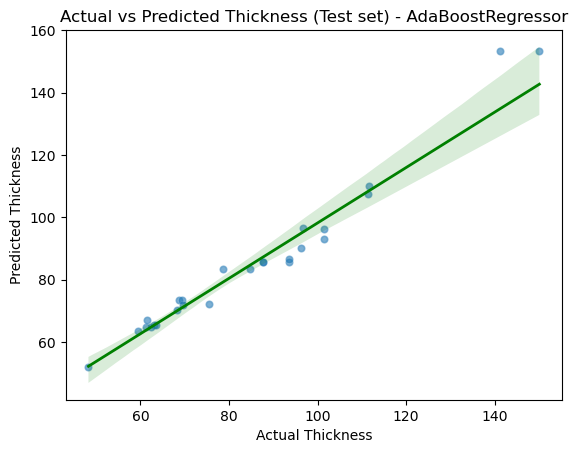

Training SVR...
Error occurred during training SVR: The model did not fit successfully.
Training RandomForestRegressor...


/home/hakki/anaconda3/envs/torch2.0/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/hakki/anaconda3/envs/torch2.0/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/hakki/anaconda3/envs/torch2.0/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/hakki/anaconda3/envs/torch2.0/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/hakki/anaconda3/envs/torch2.0/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objectiv

Finished training for RandomForestRegressor


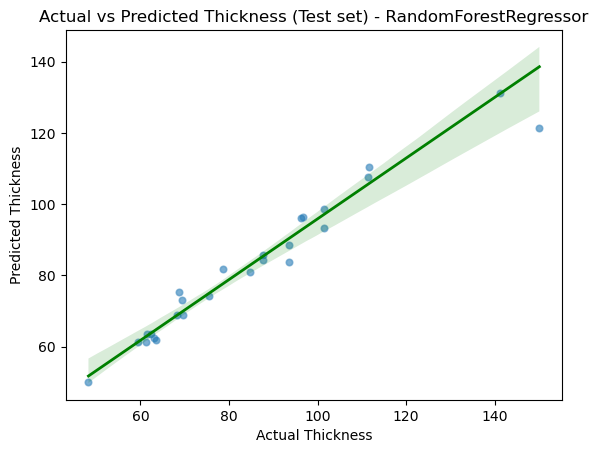

Training GaussianProcessRegressor...


/home/hakki/anaconda3/envs/torch2.0/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/hakki/anaconda3/envs/torch2.0/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/hakki/anaconda3/envs/torch2.0/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/hakki/anaconda3/envs/torch2.0/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/hakki/anaconda3/envs/torch2.0/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objectiv

Error occurred during training GaussianProcessRegressor: The model did not fit successfully.
Training Lasso...
Error occurred during training Lasso: The model did not fit successfully.
Training Ridge...
Error occurred during training Ridge: The model did not fit successfully.


In [6]:
# 모델 별로 훈련 및 테스트 수행
results = {}

for model_name in models.keys():
    model = models[model_name]
    params = search_spaces[model_name]
    try:
        print(f"Training {model_name}...")
        bayes_search = BayesSearchCV(model, 
                                     search_spaces=params, 
                                     n_iter=50, 
                                     cv=5, 
                                     n_jobs=-1,
                                     scoring=rmse_scorer, 
                                     random_state=42)
        bayes_search.fit(X_train, y_train)
        if hasattr(bayes_search.best_estimator_, "estimators_"):
            y_pred = bayes_search.predict(X_test)
        else:
            raise Exception("The model did not fit successfully.")

        # 결과 저장
        mse = mean_squared_error(y_test, y_pred)
        n_iter = len(bayes_search.cv_results_['params'])

        results[model_name] = {
            "used data feature": list(X.columns),
            "model": model_name,
            "model parameter": bayes_search.best_params_,
            "n_iter": n_iter,
            "y_test.values": list(y_test.values),
            "y_pred": list(y_pred),
            "mse": mse,
            "rmse": np.sqrt(mean_squared_error(y_test, y_pred))
        }
        print(f"Finished training for {model_name}")

        # 그래프 그리기
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
        sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True)
        plt.xlabel('Actual Thickness')
        plt.ylabel('Predicted Thickness')
        plt.title(f'Actual vs Predicted Thickness (Test set) - {model_name}')
        plt.show()

    except Exception as e:
        print(f"Error occurred during training {model_name}: {e}")
    


In [7]:
# 결과 출력
for model_name, result in results.items():
    print(f"{model_name} RMSE: {result['rmse']}")

AdaBoostRegressor RMSE: 4.815429118147299
RandomForestRegressor RMSE: 6.917012433238919
